# PREVENT-SOC Equation
Description: A cardiovascular risk equation incorporating social determinants of health

Created by: Kyla Gabriel (with supervision of Arjun Manrai, PhD)

Table of Contents:
1. Data Cleaning
2. Data Distribution
4. Baseline Correlation Model
5. Logistic Regression
6. Random Forest
7. Gradient Boosting
8. Model Validation



## 1. Data Cleaning
Purpose: Extract the data that is needed and create usable data frames

Notes to user:
* If you have the consolidated csv files labeled as "preds_var.csv" and "target_var.csv", skip to Section 2: Data Distrubution.
* Cells that start with "#####" require user input to change to correct file.
* File path is dependent on one's computer and file name is dependent on which file you wish to convert.

In [ ]:
# Open libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# drive.mount('/content/drive')    # Comment in if necessary

In [ ]:
#####
# Conversion of raw XPT to CSV (don't use if already converted)
FILE_PATH = "/content/"
FILE = "CVD"   ### Change to file name you want to open
df = pd.read_sas(FILE_PATH + FILE + '.XPT', index=None)
df.to_csv(FILE_PATH + FILE + '.csv')

Subsection 1: NHANES (2017 - Pre-Pandemic 2020)

In [ ]:
#####
# Read in data variables
var_path = "/content/drive/MyDrive/5) Capstone/Data/NHANES/CSV_Version"    ### Change to personal file location

# Predictor Variables
cvd_subset  = pd.read_csv(f"{var_path}/CVD.csv", usecols=["SEQN","MCQ160B", "MCQ160C", "MCQ160D"])
cvd = cvd_subset[(cvd_subset["MCQ160B"] == 1) | (cvd_subset["MCQ160C"] == 1) | (cvd_subset["MCQ160D"] == 1)]
cvd.rename(columns={'SEQN': 'PatientID', 'MCQ160B': 'CHF', 'MCQ160C': 'CAD', 'MCQ160D': 'AP'}, inplace=True)

# Clinical Variables
age = pd.read_csv(f"{var_path}/Demographics.csv")[["SEQN","RIDAGEYR"]]
sex = pd.read_csv(f"{var_path}/Demographics.csv")[["SEQN","RIAGENDR"]]
tot_chol = pd.read_csv(f"{var_path}/Total_Chol.csv")[["SEQN","LBXTC"]]
hdl_chol = pd.read_csv(f"{var_path}/HDL.csv")[["SEQN","LBDHDD"]]
sys_bp = pd.read_csv(f"{var_path}/BP.csv")[["SEQN","BPXOSY1"]]
bmi = pd.read_csv(f"{var_path}/BMI.csv")[["SEQN","BMXBMI"]]
egfr = pd.read_csv(f"{var_path}/egfr.csv")[["SEQN","URXUCR"]]
uacr = pd.read_csv(f"{var_path}/UACR.csv")[["SEQN","URDACT"]]
hba1c = pd.read_csv(f"{var_path}/DiabStatus.csv")[["SEQN","DIQ280"]]

# Biomarker Statuses
htn_df = pd.read_csv(f"{var_path}/htn.csv")
htn_med = htn_df[htn_df["RXDRSC1"].str.contains("b'I10' | b'I10.P'", na=False)]
lipid_med = htn_df[htn_df["RXDRSC1"].str.contains("b'E78.0'|b'E78.0P'", na=False)]
smoking = pd.read_csv(f"{var_path}/Smoking.csv")[["SEQN","SMQ040"]]
diabetic = pd.read_csv(f"{var_path}/DiabStatus.csv")[["SEQN","DIQ010"]]

# Social Determinants of Health
ses = pd.read_csv(f"{var_path}/Demographics.csv")[["SEQN","INDFMPIR"]]
edu = pd.read_csv(f"{var_path}/Demographics.csv")[["SEQN","DMDEDUC2"]]
access = pd.read_csv(f"{var_path}/access.csv")[["SEQN","HUQ030"]]
employed = pd.read_csv(f"{var_path}/employed.csv")[["SEQN","OCD150"]]
food_sec = pd.read_csv(f"{var_path}/security.csv")[["SEQN","FSDHH"]]

<ipython-input-6-dbed2c064f7b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvd.rename(columns={'SEQN': 'PatientID', 'MCQ160B': 'CHF', 'MCQ160C': 'CAD', 'MCQ160D': 'AP'}, inplace=True)


In [ ]:
# Merge data frames by SEQN number
predictors = age.merge(sex, on='SEQN', how='outer')
predictors = predictors.merge(tot_chol, on='SEQN', how='outer')
predictors = predictors.merge(hdl_chol, on='SEQN', how='outer')
predictors = predictors.merge(sys_bp, on='SEQN', how='outer')
predictors = predictors.merge(bmi, on='SEQN', how='outer')
predictors = predictors.merge(egfr, on='SEQN', how='outer')
predictors = predictors.merge(uacr, on='SEQN', how='outer')
predictors = predictors.merge(hba1c, on='SEQN', how='outer')
predictors = predictors.merge(smoking, on='SEQN', how='outer')
predictors = predictors.merge(diabetic, on='SEQN', how='outer')
predictors = predictors.merge(htn_med, on='SEQN', how='outer')
predictors = predictors.merge(lipid_med, on='SEQN', how='outer')
predictors = predictors.merge(ses, on='SEQN', how='outer')
predictors = predictors.merge(edu, on='SEQN', how='outer')
predictors = predictors.merge(access, on='SEQN', how='outer')
predictors = predictors.merge(employed, on='SEQN', how='outer')
predictors = predictors.merge(food_sec, on='SEQN', how='outer')

# Separate medication columns into two distinct columns
predictors['HTN_Med'] = ((predictors['RXDRSC1_y'] == "b'I10'") | (predictors['RXDRSC1_y'] == "b'I10.P'")).astype(int)
predictors['Lipid_Med'] = ((predictors['RXDRSC1_y'] == "b'E78.0'") | (predictors['RXDRSC1_y'] == "b'E78.0P")).astype(int)

# Delete unnecessary columns (added from medication variable)
predictors = predictors.drop(columns=['Unnamed: 0_x','RXDUSE_x','RXDDRUG_x',
                                      'RXDDRGID_x','RXQSEEN_x','RXDDAYS_x',
                                      'RXDRSC1_x','RXDRSC2_x','RXDRSC3_x',
                                      'RXDRSD1_x','RXDRSD2_x','RXDRSD3_x',
                                      'RXDCOUNT_x','Unnamed: 0_y','RXDDRGID_y',
                                      'RXQSEEN_y','RXDDAYS_y','RXDUSE_y',
                                      'RXDRSC2_y','RXDRSC3_y','RXDCOUNT_y',
                                      'RXDRSD1_y','RXDRSD2_y','RXDRSD3_y',
                                      'RXDDRUG_y','RXDRSC1_y'])

# Fix column names
predictors.rename(columns={'SEQN':'PatientID','RIDAGEYR':'Age','RIAGENDR':'Sex',
                          'LBXTC':'Total_Chol','LBDHDD':'HDL_Chol','BPXOSY1':'SBP',
                          'BMXBMI':'BMI','URXUCR':'Creatinine','URDACT':'eGFR',
                          'DIQ280':'HbA1c','SMQ040':'Smoker','DIQ010':'Diabetic',
                          'INDFMPIR':'Inc_Ratio','DMDEDUC2':'Edu','HUQ030':'Access',
                          'OCD150':'Job','FSDHH':'Food_Sec','HTN_Med':'HTN_Med',
                          'Lipid_Med':'Lipid_Med'}, inplace=True)

# Save to csv file
cvd.to_csv('target_var.csv')
predictors.to_csv('preds_var.csv')

Subsection 2: ARHQ (2020)

## 2. Data Distribution
Purpose: Understand what the data looks like and visualize any missing data

In [ ]:
# Read in files
target_var = pd.read_csv(f"{var_path}/target_var.csv")
preds_var = pd.read_csv(f"{var_path}/preds_var.csv")

In [ ]:
# Variable range
def calculate_range(df):
    return df.max() - df.min()

target_var_range = calculate_range(target_var)
preds_var_range = calculate_range(preds_var)

print("The range for the target variables include:")
print(target_var_range)
print("The range for the predictor variables include:")
print(preds_var_range)

The range for the target variables include:
Unnamed: 0    14889.0
PatientID     15458.0
CHF               8.0
CAD               8.0
AP                8.0
dtype: float64
The range for the predictor variables include:
Unnamed: 0    15646.00
PatientID     15559.00
Age              80.00
Sex               1.00
Total_Chol      375.00
HDL_Chol        184.00
SBP             173.00
BMI              80.40
Creatinine      735.46
eGFR          11676.65
HbA1c           996.70
Smoker            2.00
Diabetic          8.00
Inc_Ratio         5.00
Edu               8.00
Access            8.00
Job               8.00
Food_Sec          3.00
HTN_Med           0.00
Lipid_Med         1.00
dtype: float64


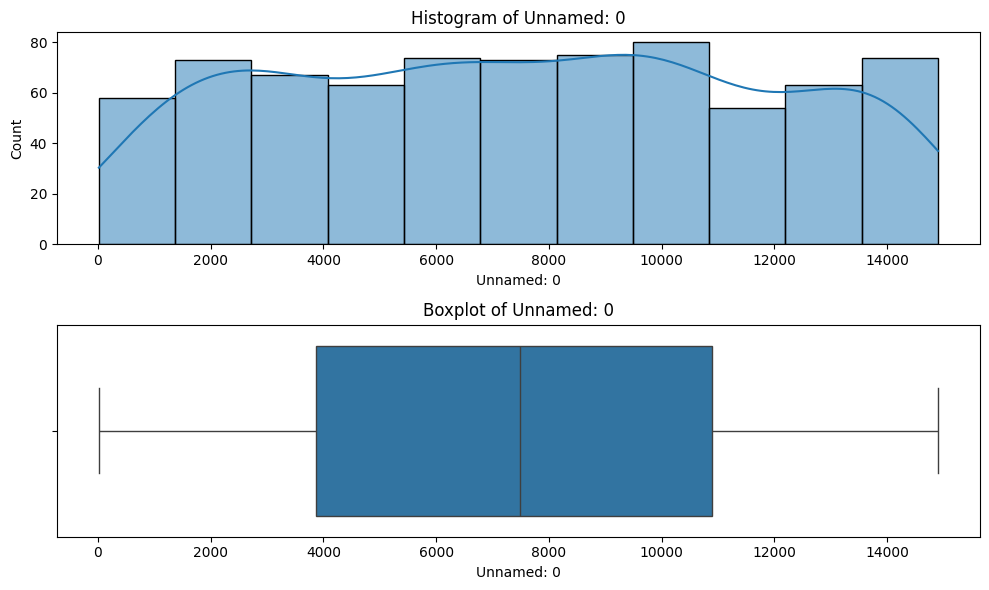

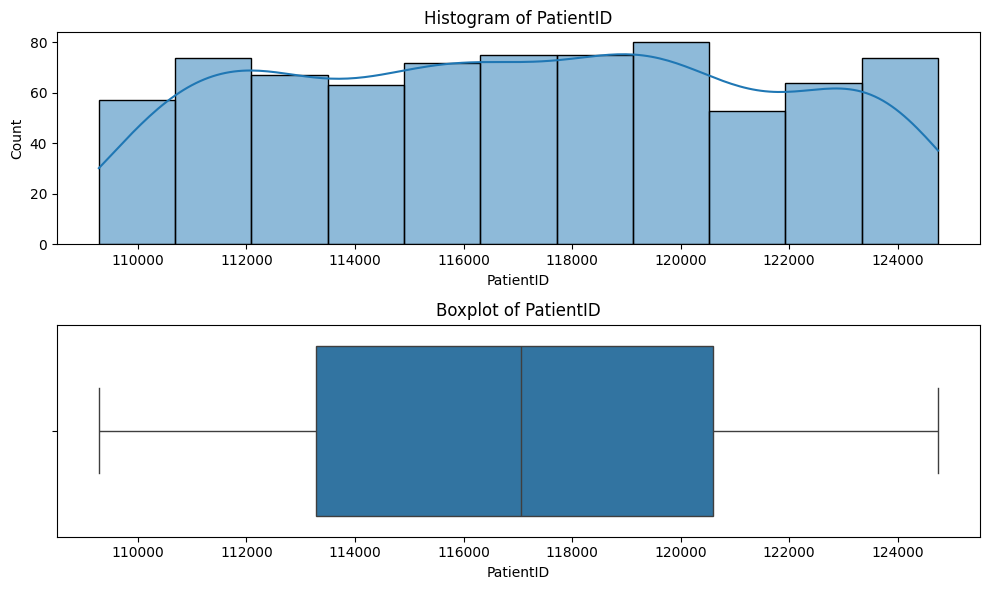

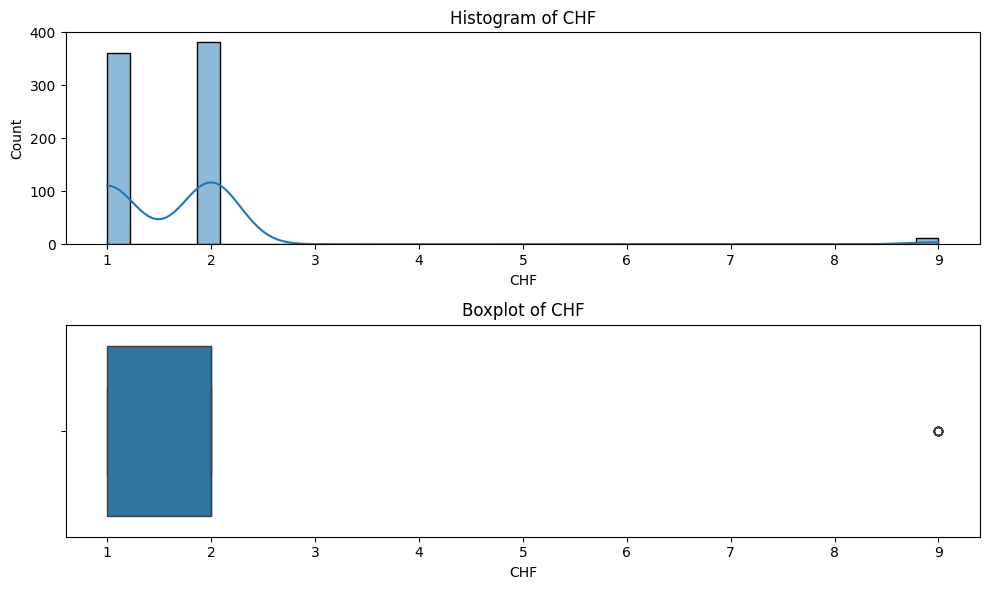

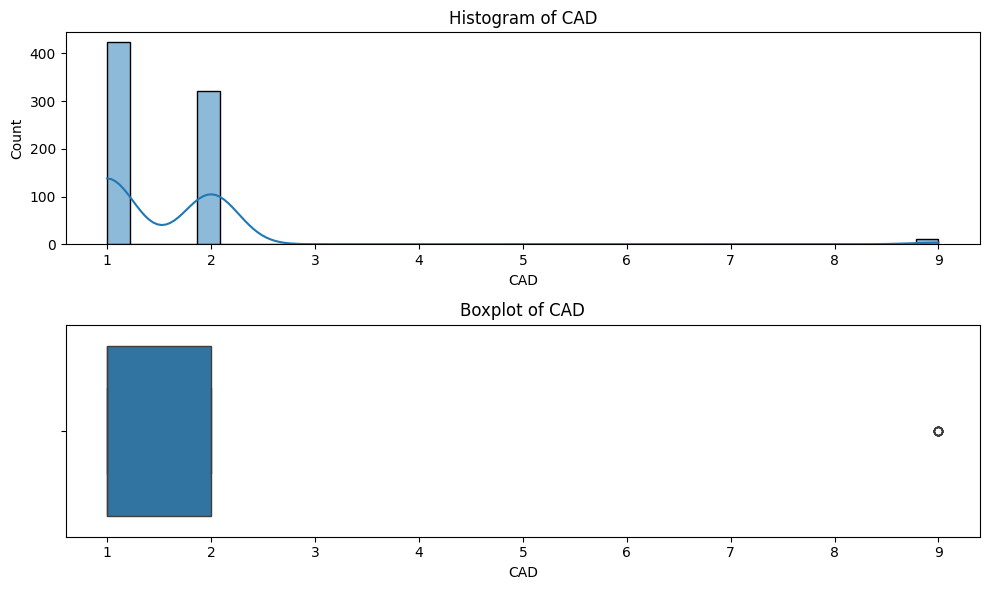

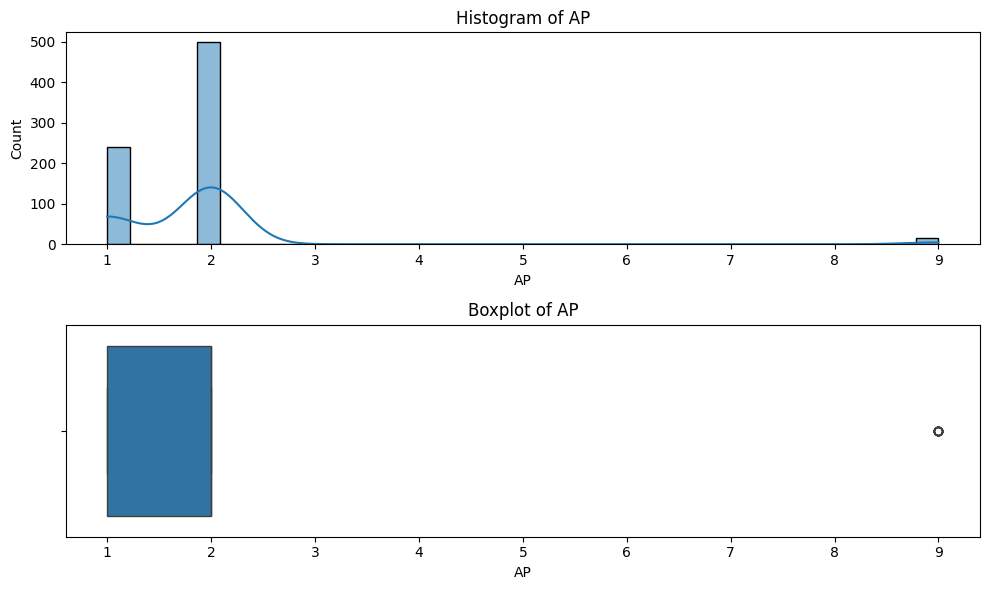

In [ ]:
# Variable distribution plots
def plot_distributions(df):
    for column in df.columns:
        plt.figure(figsize=(10, 6))

        if pd.api.types.is_numeric_dtype(df[column]):
            # Plot histogram and boxplot for numeric columns
            plt.subplot(2, 1, 1)
            sns.histplot(df[column].dropna(), kde=True)
            plt.title(f'Histogram of {column}')

            plt.subplot(2, 1, 2)
            sns.boxplot(x=df[column])
            plt.title(f'Boxplot of {column}')

        else:
            # Plot bar plot for categorical columns
            sns.countplot(y=df[column], order=df[column].value_counts().index, palette='viridis')
            plt.title(f'Bar Plot of {column}')

        plt.tight_layout()
        plt.show()

#plot_distributions(preds_var)  # Comment in to see the plots

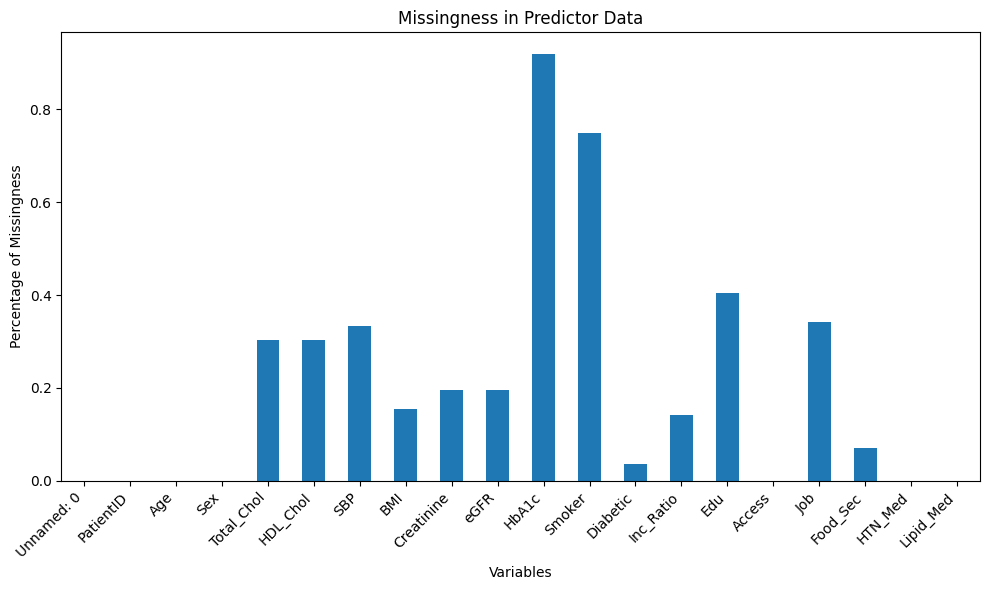

In [ ]:
# Variable missingness
def calculate_missingness(df):
    miss = df.isnull().sum()
    percent = miss/df.shape[0]
    return percent

target_var_miss = calculate_missingness(target_var) # Note: no missing data found
preds_var_miss = calculate_missingness(preds_var)

# Visualize data
plt.figure(figsize=(10, 6))
preds_var_miss.plot(kind='bar')
plt.xlabel('Variables')
plt.ylabel('Percentage of Missingness')
plt.title('Missingness in Predictor Data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#  Account for the missing values
imputer = KNNImputer(n_neighbors=5)
preds_var_impute = imputer.fit_transform(preds_var)

# Normalize the data
scaler = StandardScaler()
preds_var_scale = scaler.fit_transform(preds_var_impute)

# Convert back to data frame
preds_var_final = pd.DataFrame(preds_var_scale, columns=preds_var.columns)